# Projekat 2 - 40 bodova

Dati su FASTQ fajlovi koji su rezultat sekvenciranja dela exoma koji se nalazi na hromozomu 11 (podaci su uzeti iz uzoraka 1000 Genomes projekta).
(tabela sa imenom uzoraka koji je dodeljen svakom studentu je data u fajlu Lista zadataka 2 2020).

### Rok za predaju je 5. Jun.
Do datog roka je potrebno poslati rezultate emailom, na adresu grakocevic@raf.rs.

Kao rezultat projekta se potrebno je predati:  
1. Kod kojim su generisani rezultati (ipynb ili python skripta)
2. Kraći izveštaj sa tekstualnim odgovorima na pitanja i grafikonima

Projekat je moguće raditi pojedinačno ili u paru. **Ukoliko se projekat radi u paru, svaki student predaje i brani projekat posebno, uz napomenu da je projekat urađen u paru; pri tome svaki student treba da obradi podatke iz eksperimenta koji mu dodeljen, a rad u paru se odnosi na programski kod i šablon za tekstualni izveštaj.**



### Pitanja:

1. [5 boda] Izvršiti kontrolu kvaliteta FASTQ fajlova alatom FastQC. Priložiti izvrštaj i diskutovati rezultate (da li je neki od kriterijuma koje analizira FastQC označen kao problematičan, i šta taj kriterijum znači?)
 
2. [5 bodova] Mapirati sekvencirane readove na referentni genom hg38 upotrebom alata BWA Mem. Upotrebom python biblioteke pysam odrediti sledeće:
 2a. Koliko je readova uspešno mapirano?
 2b. Koliko je parova readova mapirano tako da su oba para mapirana?
 2c. Nacrtati histogram dužina sekvenciranih fragmenata (*template_length*). 
   
3. [8 bodova] Izvršiti obradu dobijenog BAM fajla prema GATK protokolu (Markiranje Duplikata, rekalibracija kvaliteta baza)
 3a. Koliki su procenati PCR i optičkih duplikata?

4. [7 bodova] Identifikovati mutacije upotrebom alata Haplotype Caller i filtirtati mutacije predefinisanim filterima (hard filtering) prema Broad preporukama (kao što je rađeno na vežbama).
 4a. Koliko je ukupno mutacija identifikovano, koliko od njih su SNP-ovi, a koliko INDEL-i?
 4b. Koliko mutacija prolazi, a koliko ne prolazi kriterijume filtriranja.
 4c. Izračunati Ti/Tv odnos pre i posle filtriranja.

5. [5 bodova] Anotirati mutacije alatom Funcotator
 5a. Izbrojati različite vrednosti ClinVar značajnosti (anotacija *ClinVar_VCF_CLNSIG*, koliko mutacija je označeno kao *Benign*, *Likely_benign*, itd.)-.

5. [10 bodova] Svi uzorici sadrže određenu količinu kontaminacije DNK materijalom bakterijskog ili virusnog porekla. Većina ovakvih readova se neće mapirati na ljudski genom. Izvući readove koji nisu mapirani u procesu mapiranja, asemblovati ih alatom abyss, i identifikovati organizam od kojeg potiče najduži skafold upotrebom alata Blast.

Mount Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Define file and directory aliases

In [0]:
root_dir = '/content/'
tools_dir = root_dir + 'tools/'
func_dir = root_dir + 'funcotator_dataSources.v1.6.20190124g/'
home_dir = root_dir + 'drive/My\ Drive/Colab\ Notebooks/UUB/'
bwa_dir = tools_dir + 'bwa/'
data_dir = home_dir + 'data/'

sample_file_1 = 'data/sample_9.pe1'
sample_file_2 = 'data/sample_9.pe2'

map_file = 'data/sample_9.map'
unmap_file = root_dir + 'sample_9.unmap.bam'

genome_file = 'data/Homo_sapiens_assembly38.fasta'
dbsnp_file = 'data/Homo_sapiens_assembly38.dbsnp138.vcf'

Define command aliases

In [0]:
fastqc = tools_dir + 'FastQC/fastqc'
bwa = bwa_dir + 'bwa'
picard = 'java -jar ' + tools_dir + 'picard.jar'
gatk = 'java -jar ' + tools_dir + 'gatk-4.1.4.1/gatk-package-4.1.4.1-local.jar'

Setup environment

In [0]:
!mkdir -p {tools_dir}
%cd {home_dir}

Unzip FASTQ archive if needed

In [0]:
!gunzip {sample_file_1}.fq.gz {sample_file_2}.fq.gz

Install FastQC

In [0]:
!wget -P {tools_dir} https://www.bioinformatics.babraham.ac.uk/projects/fastqc/fastqc_v0.11.9.zip
!unzip {tools_dir}fastqc_v0.11.9.zip -d {tools_dir}
!rm {tools_dir}fastqc_v0.11.9.zip
!chmod 755 {fastqc}

Install BWA

In [0]:
!git clone https://github.com/lh3/bwa.git {bwa_dir}
!cd {bwa_dir} && make

Install SAMtools

In [0]:
!apt-get install samtools

Install GATK

In [0]:
!wget -O {tools_dir}gatk-4.1.4.1.zip 'https://github.com/broadinstitute/gatk/releases/download/4.1.4.1/gatk-4.1.4.1.zip'
!unzip {tools_dir}gatk-4.1.4.1.zip -d {tools_dir}
!R -e 'install.packages(c("gplots", "gsalib"))'

Install Picard

In [0]:
!wget -P {tools_dir} https://github.com/broadinstitute/picard/releases/download/2.21.6/picard.jar

Install ABySS

In [0]:
!apt-get install abyss

Download hg38 assembly

In [0]:
!gsutil cp gs://genomics-public-data/resources/broad/hg38/v0/Homo_sapiens_assembly38.fasta {data_dir}
!gsutil cp gs://genomics-public-data/resources/broad/hg38/v0/Homo_sapiens_assembly38.fasta.fai {data_dir}
!gsutil cp gs://genomics-public-data/resources/broad/hg38/v0/Homo_sapiens_assembly38.dict {data_dir}

Download dbSNP

In [0]:
!gsutil cp gs://genomics-public-data/resources/broad/hg38/v0/Homo_sapiens_assembly38.dbsnp138.vcf data
!gsutil cp gs://genomics-public-data/resources/broad/hg38/v0/Homo_sapiens_assembly38.dbsnp138.vcf.idx data

Install PySAM library

In [0]:
!pip install pysam

Import required libraries

In [0]:
import math
import pysam
import matplotlib.pyplot as plt

Run quality control

In [0]:
!{fastqc} {sample_file_1}.fq {sample_file_2}.fq

Create index files

In [0]:
!{bwa} index {genome_file}

Run sequance mapping on hg38 assembly

In [0]:
!{bwa} mem {genome_file} {sample_file_1}.fq {sample_file_2}.fq > {map_file}.sam

Sort and index mapping output file

In [0]:
!samtools view -b -o {map_file}.bam {map_file}.sam
!samtools sort -o {map_file}.sorted.bam {map_file}.bam
!samtools index {map_file}.sorted.bam

Count mapped reads and pairs

In [0]:
bam_fragments = pysam.AlignmentFile(map_file + '.sorted.bam', 'rb')
fragments = list(bam_fragments.fetch(until_eof=True))

mapped_reads = bam_fragments.mapped
mapped_pairs = sum([len(f.get_aligned_pairs(matches_only=True)) for f in fragments])

print('Mapped reads={}'.format(mapped_reads))
print('Mapped pairs={}'.format(mapped_pairs))

Show read template lengths histogram

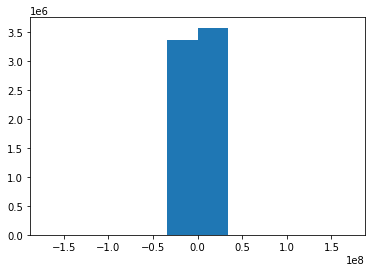

In [0]:
frag_lengths = [f.template_length for f in fragments]

plt.hist(frag_lengths)
plt.show()

Run GATK pipeline (duplicate reads marking)

In [0]:
!{picard} MarkDuplicates I={map_file}.sorted.bam O={map_file}.dup.bam M={map_file}.dup.txt

Count duplicate reads

In [0]:
dup = pysam.AlignmentFile(map_file + '.dup.bam')
dup_len = len([x for x in dup if x.is_duplicate])

print('Duplicate reads={}'.format(dup_len))

Run GATK pipeline (quality recalibration)

In [0]:
!{picard} AddOrReplaceReadGroups I={map_file}.dup.bam O={map_file}.gr.dup.bam RGID=4 RGLB=lib1 RGPL=illumina RGPU=unit1 RGSM=20
!{gatk} BaseRecalibrator -I {map_file}.gr.dup.bam --known-sites {dbsnp_file} -O {map_file}.cal.tbl --reference {genome_file}
!{gatk} ApplyBQSR -I {map_file}.gr.dup.bam -bqsr {map_file}.cal.tbl -O {map_file}.cal.bam
!{gatk} BaseRecalibrator -I {map_file}.cal.bam --known-sites {dbsnp_file} -O {map_file}.post.cal.tbl --reference {genome_file}
!{gatk} AnalyzeCovariates -before {map_file}.cal.tbl -after {map_file}.post.cal.tbl -plots {map_file}.cmp.pdf

Identify mutations using dbSNP

In [0]:
!{gatk} HaplotypeCaller --input {map_file}.cal.bam --output {map_file}.vcf --reference {genome_file} --dbsnp {dbsnp_file} -L chr11

Define mutation filtering helper functions

In [0]:
def is_snp(variant):
    return len(variant.ref) == 1 and len(variant.alts[0]) == 1

def is_transitions(variant):
    allels = set((variant.ref, variant.alts[0]))
    return allels == {'A', 'G'} or allels == {'C', 'T'}

def get_titv_ratio(variants):
    ti = sum(1 for v in variants if is_snp(v) and is_transitions(v))
    tv = sum(1 for v in variants if is_snp(v) and not is_transitions(v))
    return ti / tv

def is_filtered(variant):
    return 'PASS' not in variant.filter

Count SNP/INDEL mutations and calculate TiTv ratio before filtering

In [0]:
vcf_variants = pysam.VariantFile(map_file + '.vcf')
variants = list(vcf_variants.fetch())

snp_count = sum(1 for v in variants if is_snp(v))
indel_count = len(variants) - snp_count

print('SNP={} INDEL={}'.format(snp_count, indel_count))
print('Ti/Tv before filtering={}'.format(get_titv_ratio(variants)))

Perform hard filtering by Broad Institute recommendations

In [0]:
snp_f = 'QD < 2.0 || FS > 60.0 || MQ < 40.0 || MQRankSum < -12.5 || ReadPosRankSum < -8.0'
indel_f = 'QD < 2.0 || FS > 200.0 || ReadPosRankSum < -20.0'

!{gatk} SelectVariants -R {genome_file} -V {map_file}.vcf -O {map_file}.snp.vcf --select-type-to-include SNP
!{gatk} VariantFiltration -R {genome_file} -V {map_file}.snp.vcf -O {map_file}.snp.fil.vcf -filter '{snp_f}' --filter-name 'snp'
!{gatk} SelectVariants -R {genome_file} -V {map_file}.vcf -O {map_file}.ind.vcf --select-type-to-include INDEL
!{gatk} VariantFiltration -R {genome_file} -V {map_file}.ind.vcf -O {map_file}.ind.fil.vcf -filter '{indel_f}' --filter-name 'indel'
!{gatk} MergeVcfs -I {map_file}.snp.fil.vcf -I {map_file}.ind.fil.vcf -O {map_file}.fil.vcf

Calculate TiTv ratio after filtering

In [0]:
vcf_filtered = pysam.VariantFile(map_file + '.fil.vcf')
filtered = list(vcf_filtered.fetch())

passing_count = len(filtered)
failing_count = len(variants) - passing_count

print('Passing mutations={}'.format(passing_count))
print('Failing mutations={}'.format(failing_count))
print('Ti/Tv after filtering={}'.format(get_titv_ratio(filtered)))

Annotate mutations

In [0]:
!cd {root_dir}
!{gatk} FuncotatorDataSourceDownloader --germline --extract-after-download
!{gatk} Funcotator -O {map_file}.ann.vcf --ref-version hg38 -R {genome_file} -V {map_file}.fil.vcf --output-file-format VCF --data-sources-path {func_dir}

Group and count mutations by ClinVar significance values


In [0]:
vcf_annotated = pysam.VariantFile(map_file + '.ann.vcf')
annotated = list(vcf_annotated.fetch())
description = vcf_annotated.header.info['FUNCOTATION'].description
functotations = description[73:].split('|')

clinvar = {}

for v in annotated:
    try:
        ann = {x:y for x, y in zip(functotations, v.info['FUNCOTATION'][0][1:-1].split('|'))}['ClinVar_VCF_CLNSIG']
        if ann in clinvar:
            clinvar[ann] += 1
        elif len(ann) > 0:
            clinvar[ann] = 1
    except UnicodeDecodeError:
        pass

for k, v in clinvar.items():
    print('{}={}'.format(k.replace('_%2C_', ''), v))

Extract all sequences which are not mapped to hg38 assembly

In [0]:
!samtools view -b -f 4 {map_file}.sorted.bam > {unmap_file}

Assemble unmapped sequences (potential bacteria or virus DNA)

In [0]:
!abyss-pe j=2 k=64 name={unmap_file}.bac in={unmap_file}

Extract longest unmapped sequence

In [0]:
fa_bacter = pysam.FastaFile(unmap_file + '.bac-1.fa')
refs = zip(fa_bacter.lengths, fa_bacter.references)
pos = sorted(refs, reverse=True)[0][1]

print(fa_bacter.fetch(pos))